# Autoencoder for MNIST

In [1]:
import tensorflow as tf
import numpy as np
from sklearn import datasets
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt

/home/rluo/anaconda3/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def read_infile():
    mnist = input_data.read_data_sets("MNIST_data/", one_hot = True)
    train_X, train_Y, test_X, test_Y = mnist.train.images, mnist.train.labels, mnist.test.images, mnist.test.labels
    return train_X, train_Y, test_X, test_Y


def en_dec_weights(n_in, n_hidden, n_out, en_dec = 'en'):
    all_layers = [n_in] + n_hidden + [n_out]
    num_layers = len(all_layers)
    X = tf.placeholder(tf.float32, [None, n_in])
    w = []
    b = []
    for i in range(1, num_layers):
        w.append(tf.Variable(tf.random_normal([all_layers[i-1], all_layers[i]], 0, 1),
                             name = f'W_{en_dec}_{i}'))
        b.append(tf.Variable(tf.zeros([all_layers[i]]), name = f'b_{en_dec}_{i}'))
    return X, w, b


def encoder_forward_pass(w, b, X):
    assert len(w) == len(b)
    out = X
    for i in range(len(w)):
        out = tf.matmul(out, w[i]) + b[i]
        out = tf.nn.sigmoid(out)
    return out


def decoder_forward_pass(w, b, X):
    assert len(w) == len(b)
    out = X
    for i in range(len(w)):
        out = tf.matmul(out, w[i]) + b[i]
        out = tf.nn.sigmoid(out)
    return out

In [3]:
train_X, train_Y, test_X, test_Y = read_infile()
with tf.device('/device:GPU:1'), tf.variable_scope('autoencoder_mnist', reuse=tf.AUTO_REUSE):
    X, w_en, b_en = en_dec_weights(train_X.shape[1], [256, 128, 64, 16, 4, 2], 2, en_dec = 'en')
    _, w_dec, b_dec = en_dec_weights(2, [4, 16, 64, 128, 256], train_X.shape[1], en_dec = 'dec')

    mid = encoder_forward_pass(w_en, b_en, X)
    out = decoder_forward_pass(w_dec, b_dec, mid)

    lam = 1e-8
    
    cost = tf.losses.mean_squared_error(X, out)
    regularizer = tf.reduce_sum([tf.nn.l2_loss(wgt) for wgt in w_en + w_dec])
    cost = cost + lam * regularizer

    epochs, batch_size = 2500, 550
    num_batches = 100

    op_train = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)

    init = tf.global_variables_initializer()
    
saver = tf.train.Saver()
epoch_loss_trace = []
test_loss_trace = []

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [4]:
with tf.Session() as sess:
    sess.run(init)
    
    for i in range(epochs):
        epoch_loss = 0

        for j in range(num_batches):
            random_indices_train = np.random.choice(len(train_X), batch_size)
            sess.run(op_train, feed_dict = {X: train_X[random_indices_train]})
            actual_batch_size = train_X[random_indices_train].shape[0]
            epoch_loss += sess.run(
                cost, feed_dict = {X: train_X[random_indices_train]})

        epoch_loss = epoch_loss / num_batches
        test_loss = sess.run(cost, feed_dict = {X: test_X})
        
        epoch_loss_trace.append(epoch_loss)
        test_loss_trace.append(test_loss)

    print(f'Final training result -- Loss: {epoch_loss}')
    print(f'results on test dataset -- Loss: {test_loss}')
    
    saver.save(sess, 'autoencoder/autoencoder_mnist.chkp')

Final training result -- Loss: 0.03667610377073288
results on test dataset -- Loss: 0.0405307337641716


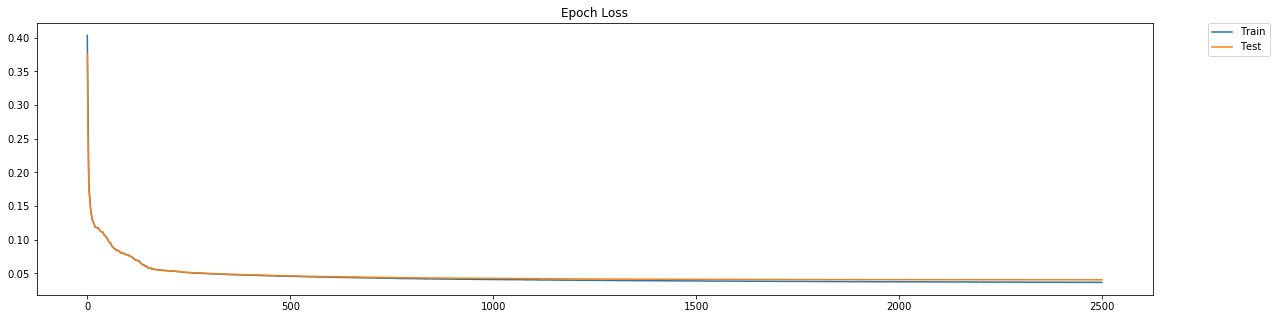

In [5]:
plt.figure(figsize=(20,5))
plt.plot(epoch_loss_trace, label='Train')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.plot(test_loss_trace, label='Test')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Epoch Loss')
plt.show()

# Reconstruction of digits

INFO:tensorflow:Restoring parameters from autoencoder/autoencoder_mnist.chkp
Actual vs reconstructed images of the digits:


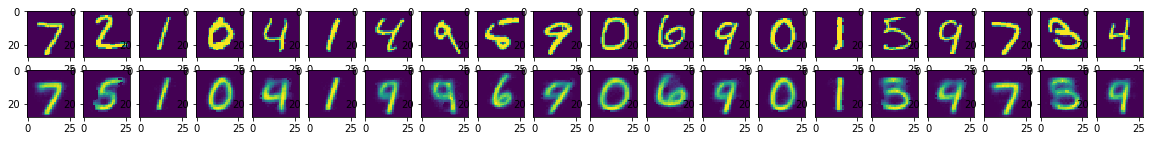

In [33]:
with tf.Session() as sess:
    sess.run(init)
    saver.restore(sess, 'autoencoder/autoencoder_mnist.chkp')

    %matplotlib inline

    f, a = plt.subplots(2, 20, figsize=(20, 2))
    actual = test_X[:20]
    mid_test = sess.run(mid, feed_dict={X: test_X})
    reconstruct = sess.run(decoder_forward_pass(w_dec, b_dec, mid), feed_dict={X: actual})
    print('Actual vs reconstructed images of the digits:')
    for j in range(20):
        a[0, j].imshow(np.reshape(actual[j], (28, 28)))
    for j in range(20):
        a[1, j].imshow(np.reshape(reconstruct[j], (28, 28)))

# Mid-layer representation of digits

In [9]:
label_test

array([7, 2, 1, ..., 4, 5, 6])

INFO:tensorflow:Restoring parameters from autoencoder/autoencoder_mnist.chkp


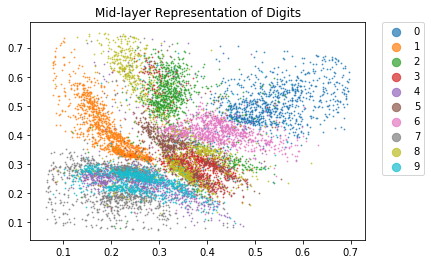

In [30]:
with tf.Session() as sess:
    sess.run(init)
    saver.restore(sess, 'autoencoder/autoencoder_mnist.chkp')
    
    mid_test = sess.run(mid, feed_dict={X: test_X})
    y_actual = test_Y
    
    label_test = np.argmax(y_actual, axis=1)
    colors = plt.cm.rainbow(np.linspace(0, 1, 10))
    x, y = mid_test[:, 0], mid_test[:, 1]

    %matplotlib inline
    for i in range(10):
        indices = (label_test == i) # color = colors[i]
        plt.scatter(x[indices], y[indices], cmap=plt.get_cmap('PiYG'), alpha=0.7, s=0.7, label=f'{i}')
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., markerscale=10)
    plt.title('Mid-layer Representation of Digits')
    plt.show()

# Hidden layer activation patterns

INFO:tensorflow:Restoring parameters from autoencoder/autoencoder_mnist.chkp


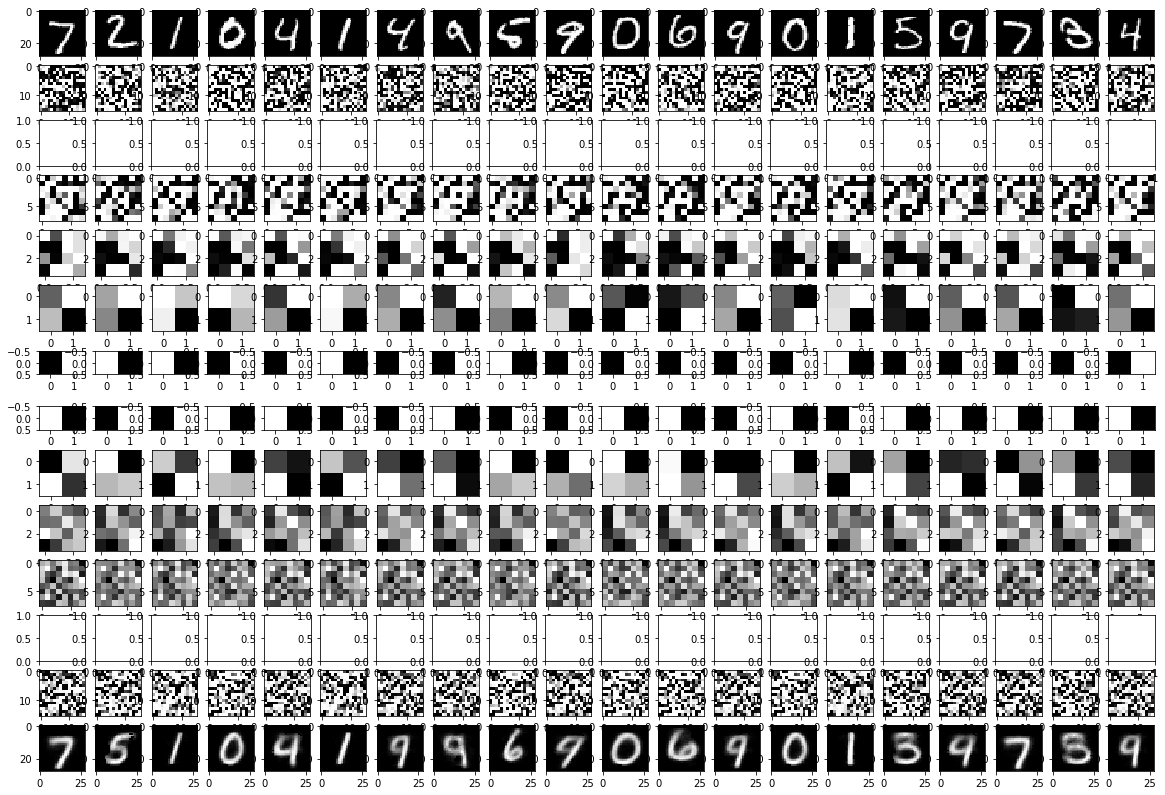

In [53]:
with tf.Session() as sess:
    sess.run(init)
    saver.restore(sess, 'autoencoder/autoencoder_mnist.chkp')

    %matplotlib inline


    ncol = 20
    sample = test_X[0:ncol]
    hids = [sample]
    n_encoder = len(w_en)
    n_decoder = len(w_dec)
    for i in range(n_encoder):
        hids.append(sess.run(tf.nn.sigmoid(tf.matmul(hids[i], w_en[i]) + b_en[i])))
    for i in range(n_decoder):
        hids.append(sess.run(tf.nn.sigmoid(tf.matmul(hids[n_encoder+i], w_dec[i]) + b_dec[i])))
    nrow = len(hids)
    
    f, a = plt.subplots(nrow, ncol, figsize = (ncol, nrow))
    for j in range(ncol):
        for i in range(nrow):
            if hids[i].shape[1] > 2:
                reshape_width = np.sqrt(hids[i].shape[1])
                if np.equal(reshape_width, int(reshape_width)):
                    reshape_width = int(reshape_width)
                    reshape_size = (reshape_width, reshape_width)
                    a[i, j].imshow(np.reshape(hids[i][j], reshape_size), cmap='gray')
            else:
                a[i, j].imshow(np.reshape(hids[i][j], (1, 2)), cmap='gray')